In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

In [2]:
print(jax.devices())

[cuda(id=0), cuda(id=1)]


In [3]:
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.cgamma import c_multi_gamma_sf, c_multi_gamma_sf_v, c_multi_gamma_prob, c_multi_gamma_prob_v 
from lib.plotting import adjust_plot_1d
from lib.simdata_i3 import I3SimHandler
from lib.geo import center_track_pos_and_time_based_on_data
from lib.network import get_network_eval_v_fn
from lib.experimental_methods import remove_early_pulses
from likelihood_spe import get_neg_c_triple_gamma_llh
#from dom_track_eval import get_eval_network_doms_and_track_altrho as get_eval_network_doms_and_track
from dom_track_eval import get_eval_network_doms_and_track

In [4]:
from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

dtype = jnp.float32

In [5]:
event_index = 1

# Get network and eval logic.
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network', dtype=dtype)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=dtype)

In [6]:
# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

muon energy: 2.0 TeV
n_doms 97


In [7]:
# Make MCTruth seed.
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("original seed vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, 
                                                                                  track_pos, 
                                                                                  track_time, 
                                                                                  track_src)
print("shifted seed vertex:", centered_track_pos)

original seed vertex: [ -57.58777311  104.94960582 -459.58699572]
shifted seed vertex: [  79.52905078  241.90677754 -291.78433739]


In [8]:
def remove_early_pulses(eval_network_doms_and_track, data, track_pos, track_dir, track_time):
    crit = -10.0
    _, _, _, geo_times = eval_network_doms_and_track(data[:,:3], track_pos, track_dir)
    delay_times = data[:, 3] - geo_times - track_time
    idx = delay_times > crit
    filtered_data = data[idx]
    return filtered_data

In [9]:
fitting_event_data = jnp.array(event_data[['x', 'y', 'z', 'time', 'charge']].to_numpy())
print(fitting_event_data.shape)

fitting_event_data = remove_early_pulses(eval_network_doms_and_track,
                                         fitting_event_data,
                                         centered_track_pos,
                                         track_src,
                                         centered_track_time)
print(fitting_event_data.shape)

(97, 5)
(97, 5)


In [10]:
def get_neg_c_triple_gamma_llh_mpe(eval_network_doms_and_track_fn):
    """
    here would be a smart docstring
    """

    @jax.jit
    def neg_c_triple_gamma_llh(track_direction,
                               track_vertex,
                               track_time,
                               event_data):
        
        # Constant parameters.
        sigma = 3.0 # width of gaussian convolution
        X_safe = 20.0 # when to stop evaluating negative time residuals in units of sigma
        delta = 0.1 # how to combine the three regions that combine approximate and exact evaluation of hyp1f1 (required for convolutions). Small values are faster. Large values are more accurate.


        dom_pos = event_data[:, :3]
        first_hit_times = event_data[:, 3]
        charges = event_data[:, 4]
        n_photons = jnp.round(charges + 0.5)
        
        logits, av, bv, geo_time = eval_network_doms_and_track_fn(dom_pos, track_vertex, track_direction)

        mix_probs = jax.nn.softmax(logits)
        delay_time = first_hit_times - (geo_time + track_time)

        # Floor on negative time residuals.
        # Effectively a floor on the pdf.
        # Todo: think about noise.
        safe_delay_time = jnp.where(delay_time > -X_safe * sigma, delay_time, -X_safe * sigma)

        probs = c_multi_gamma_prob_v(safe_delay_time, 
                                     mix_probs,
                                     av,
                                     bv,
                                     sigma,
                                     delta)

        sfs = c_multi_gamma_sf_v(safe_delay_time, mix_probs, av, bv, sigma)

        mpe_log_probs = jnp.log(n_photons) + jnp.log(probs) + (n_photons-1.0) * jnp.log(sfs)
        return -2.0 * jnp.sum(mpe_log_probs)
        #mpe_probs = n_photons * probs * jnp.power(sfs, n_photons-1.0)
        #return -2.0 * jnp.sum(jnp.log(mpe_probs))

    return neg_c_triple_gamma_llh


In [11]:
neg_llh_mpe = get_neg_c_triple_gamma_llh_mpe(eval_network_doms_and_track)
neg_llh_mpe_v = jax.jit(jax.vmap(neg_llh_mpe, (0, None, None, None), 0))

neg_llh_spe = get_neg_c_triple_gamma_llh(eval_network_doms_and_track)
neg_llh_spe_v = jax.jit(jax.vmap(neg_llh_spe, (0, None, None, None), 0))

In [12]:
print(neg_llh_spe(track_src, centered_track_pos, centered_track_time, fitting_event_data))
print(neg_llh_mpe(track_src, centered_track_pos, centered_track_time, fitting_event_data))

1351.3389686457203
1428.2044971593498


In [13]:
%timeit neg_llh_mpe(track_src, centered_track_pos, centered_track_time, fitting_event_data).block_until_ready()

4.89 ms ± 29.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%timeit neg_llh_spe(track_src, centered_track_pos, centered_track_time, fitting_event_data).block_until_ready()

1.97 ms ± 1.69 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
import optimistix as optx

scale = 20.0

@jax.jit
def neg_llh_5D_mpe(x, args):
		# project back if outside of [0, pi] x [0, 2*pi]
        zenith = x[0] / scale
        azimuth = x[1] / scale
        zenith = jnp.fmod(zenith, 2.0*jnp.pi)
        zenith = jnp.where(zenith < 0, zenith+2.0*jnp.pi, zenith)
        cond = zenith > jnp.pi
        zenith = jnp.where(cond, -1.0*zenith+2.0*jnp.pi, zenith)
        azimuth = jnp.where(cond, azimuth-jnp.pi, azimuth)

        azimuth = jnp.fmod(azimuth, 2.0*jnp.pi)
        azimuth = jnp.where(azimuth < 0, azimuth+2.0*jnp.pi, azimuth)

        projected_dir = jnp.array([zenith, azimuth])
        return neg_llh_mpe(projected_dir, x[2:]*scale, centered_track_time, fitting_event_data)

@jax.jit
def neg_llh_5D_spe(x, args):
		# project back if outside of [0, pi] x [0, 2*pi]
        zenith = x[0] / scale
        azimuth = x[1] / scale
        zenith = jnp.fmod(zenith, 2.0*jnp.pi)
        zenith = jnp.where(zenith < 0, zenith+2.0*jnp.pi, zenith)
        cond = zenith > jnp.pi
        zenith = jnp.where(cond, -1.0*zenith+2.0*jnp.pi, zenith)
        azimuth = jnp.where(cond, azimuth-jnp.pi, azimuth)

        azimuth = jnp.fmod(azimuth, 2.0*jnp.pi)
        azimuth = jnp.where(azimuth < 0, azimuth+2.0*jnp.pi, azimuth)

        projected_dir = jnp.array([zenith, azimuth])
        return neg_llh_spe(projected_dir, x[2:]*scale, centered_track_time, fitting_event_data)

In [16]:
solver = optx.BFGS(rtol=1e-7, atol=1e-3, use_inverse=True)
x0 = jnp.concatenate([track_src*scale, centered_track_pos/scale])
best_x = optx.minimise(neg_llh_5D_spe, solver, x0).value
best_logl = neg_llh_5D_spe(best_x, None)

print("... solution found.")
print(f"-2*logl={best_logl:.3f}")
print(f"zenith={best_x[0]/scale:.3f}rad")
print(f"azimuth={best_x[1]/scale:.3f}rad")
print(f"x={best_x[2]*scale:.3f}m")
print(f"y={best_x[3]*scale:.3f}m")
print(f"z={best_x[4]*scale:.3f}m")
print(f"at fix time t={centered_track_time:.3f}ns")

... solution found.
-2*logl=1341.336
zenith=2.292rad
azimuth=3.919rad
x=79.410m
y=241.693m
z=-290.790m
at fix time t=10489.521ns


In [17]:
%timeit optx.minimise(neg_llh_5D_spe, solver, x0).value.block_until_ready()

49.7 ms ± 59.6 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
print(neg_llh_5D_mpe(best_x, None))

1439.8207716596494


In [19]:
solver = optx.BFGS(rtol=1e-7, atol=1e-3, use_inverse=True)
x0 = jnp.concatenate([track_src*scale, centered_track_pos/scale])
best_x = optx.minimise(neg_llh_5D_mpe, solver, x0).value
best_logl = neg_llh_5D_mpe(best_x, None)

print("... solution found.")
print(f"-2*logl={best_logl:.3f}")
print(f"zenith={best_x[0]/scale:.3f}rad")
print(f"azimuth={best_x[1]/scale:.3f}rad")
print(f"x={best_x[2]*scale:.3f}m")
print(f"y={best_x[3]*scale:.3f}m")
print(f"z={best_x[4]*scale:.3f}m")
print(f"at fix time t={centered_track_time:.3f}ns")

... solution found.
-2*logl=1412.351
zenith=2.286rad
azimuth=3.908rad
x=77.809m
y=241.992m
z=-292.698m
at fix time t=10489.521ns


In [20]:
%timeit optx.minimise(neg_llh_5D_mpe, solver, x0).value.block_until_ready()

537 ms ± 936 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
# Number of scan points on 1D
n_eval = 100 # making it a 100x100 grid

# Scan range (truth +/- dzen, +/- dazi)
dzen = 0.03 # rad
dazi = 0.03 # rad

zenith = jnp.linspace(track_src[0]-dzen, track_src[0]+dazi, n_eval)
azimuth = jnp.linspace(track_src[1]-dzen, track_src[1]+dazi, n_eval)
X, Y = jnp.meshgrid(zenith, azimuth)
init_dirs = jnp.column_stack([X.flatten(), Y.flatten()])

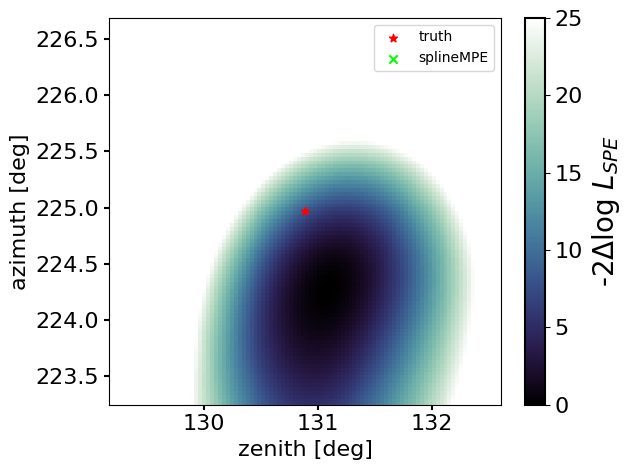

In [22]:
logls = neg_llh_spe_v(init_dirs, centered_track_pos, centered_track_time, fitting_event_data)
logls = logls.reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([25, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{SPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')


plt.legend()
plt.tight_layout()
plt.show()

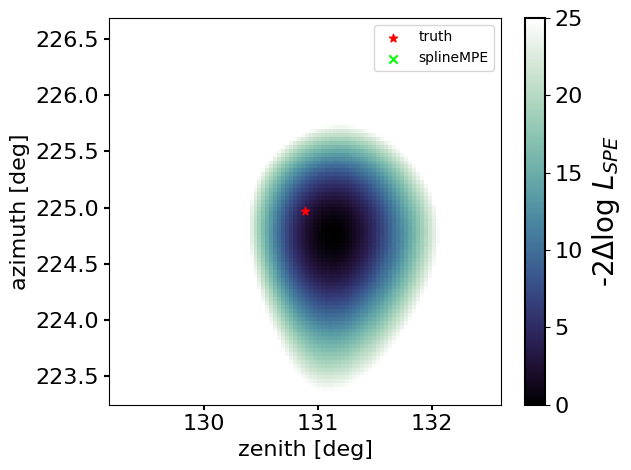

In [23]:
logls = neg_llh_mpe_v(init_dirs, centered_track_pos, centered_track_time, fitting_event_data)
logls = logls.reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([25, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{SPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')


plt.legend()
plt.tight_layout()
plt.show()

In [24]:
neg_llh_spe_grad = jax.jit(jax.grad(neg_llh_spe))
neg_llh_spe_grad_v = jax.jit(jax.vmap(neg_llh_spe_grad, (0, None, None, None), 0))

neg_llh_mpe_grad = jax.jit(jax.grad(neg_llh_mpe))
neg_llh_mpe_grad_v = jax.jit(jax.vmap(neg_llh_mpe_grad, (0, None, None, None), 0))

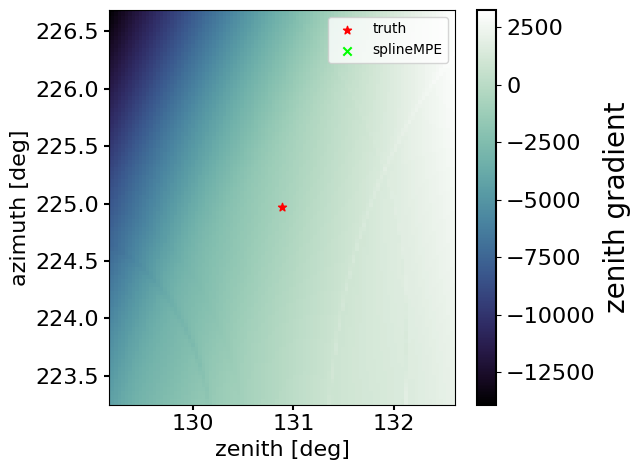

In [25]:
grads = neg_llh_spe_grad_v(init_dirs, centered_track_pos, centered_track_time, fitting_event_data)

grads0 = grads[:,0].reshape(X.shape)
grads1 = grads[:,1].reshape(X.shape)

fig, ax = plt.subplots()
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), grads0, 
                   vmin=np.amin(grads0), vmax=np.amax(grads0), shading='auto', cmap=cx)

cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("zenith gradient", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

plt.legend()
plt.tight_layout()
plt.show()

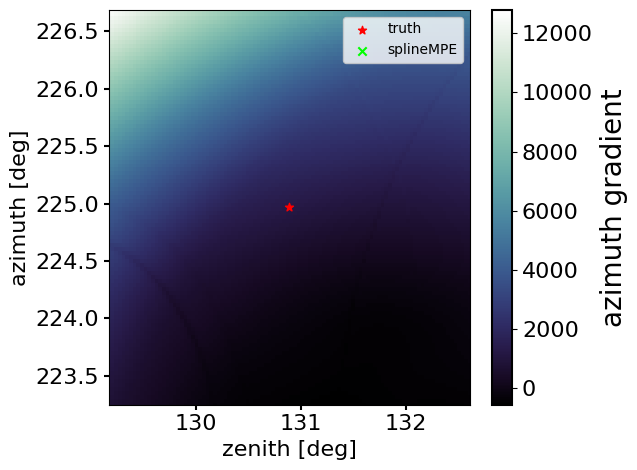

In [26]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), grads1, 
                   vmin=np.amin(grads1), vmax=np.amax(grads1), shading='auto', cmap=cx)

cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("azimuth gradient", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

plt.legend()
plt.tight_layout()
plt.show()

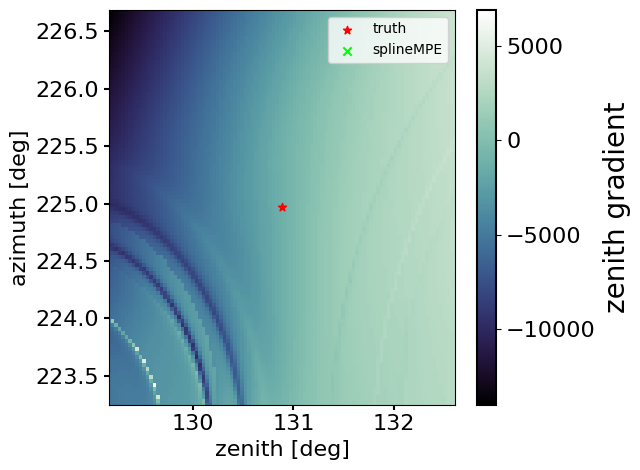

In [27]:
grads = neg_llh_mpe_grad_v(init_dirs, centered_track_pos, centered_track_time, fitting_event_data)

grads0 = grads[:,0].reshape(X.shape)
grads1 = grads[:,1].reshape(X.shape)

fig, ax = plt.subplots()
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), grads0, 
                   vmin=np.amin(grads0), vmax=np.amax(grads0), shading='auto', cmap=cx)

cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("zenith gradient", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

plt.legend()
plt.tight_layout()
plt.show()

In [28]:
print(grads)

[[-5193.75057872  1121.67855832]
 [-5119.7045012   1185.86229289]
 [-5042.65891258  1238.9670841 ]
 ...
 [ 3728.06244938  5700.76269314]
 [ 3837.31991484  5703.70104597]
 [ 3948.30356827  5711.85226458]]


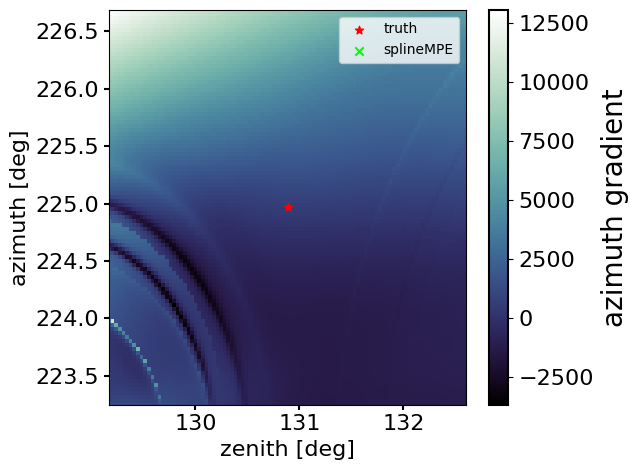

In [29]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), grads1, 
                   vmin=np.amin(grads1), vmax=np.amax(grads1), shading='auto', cmap=cx)

cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("azimuth gradient", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

plt.legend()
plt.tight_layout()
plt.show()

In [43]:
@jax.jit
def finite_difference_grad(track_direction, track_pos, track_time, fitting_event_data):
    eps = 1.e-3
    
    track_direction1 = track_direction + jnp.array([eps, 0.0])
    track_direction2 = track_direction - jnp.array([eps, 0.0])
    fval1 = neg_llh_mpe(track_direction1, track_pos, track_time, fitting_event_data)
    fval2 = neg_llh_mpe(track_direction2, track_pos, track_time, fitting_event_data)
    grad1 = (fval1 - fval2)/(2*eps)

    track_direction1 = track_direction + jnp.array([0.0, eps])
    track_direction2 = track_direction - jnp.array([0.0, eps])
    fval1 = neg_llh_mpe(track_direction1, track_pos, track_time, fitting_event_data)
    fval2 = neg_llh_mpe(track_direction2, track_pos, track_time, fitting_event_data)
    grad2 = (fval1 - fval2)/(2*eps)
    
    return jnp.array([grad1, grad2])

finite_diff_grad_v = jax.jit(jax.vmap(finite_difference_grad, (0, None, None, None), 0))

In [44]:
grads = finite_diff_grad_v(init_dirs, centered_track_pos, centered_track_time, fitting_event_data)
grads0 = grads[:,0].reshape(X.shape)
grads1 = grads[:,1].reshape(X.shape)

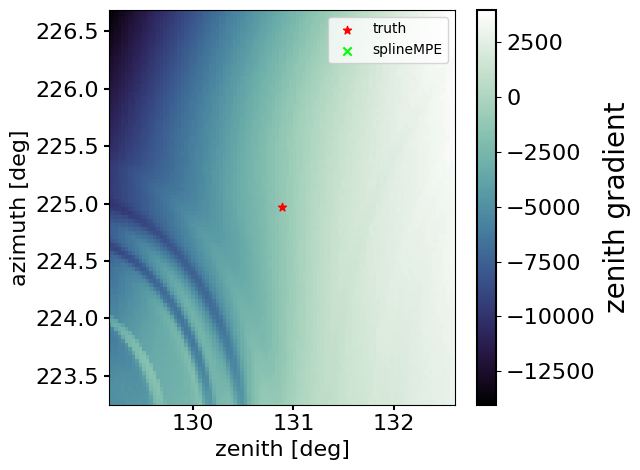

In [45]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), grads0, 
                   vmin=np.amin(grads0), vmax=np.amax(grads0), shading='auto', cmap=cx)

cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("zenith gradient", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

plt.legend()
plt.tight_layout()
plt.show()

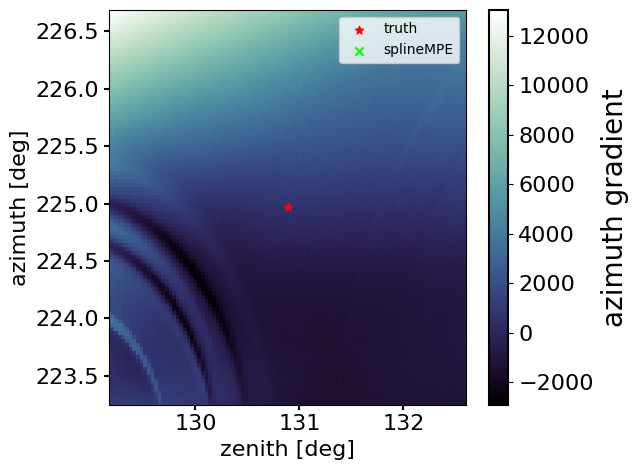

In [46]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), grads1, 
                   vmin=np.amin(grads1), vmax=np.amax(grads1), shading='auto', cmap=cx)

cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("azimuth gradient", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

plt.legend()
plt.tight_layout()
plt.show()

In [34]:
jax.devices()

[cuda(id=0), cuda(id=1)]